In [1]:
# Suppressing warnings
import warnings
warnings.filterwarnings(action = "ignore")

import quadratic2SLS as q2sls
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Plotting preferences
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

In [17]:
## ~~~~~ Functions ~~~~~ ##

## Coefficient Results Table ##
def results_df(results_obj, true_coeffs):
    '''Returns summary of coefficient results compared to true coeff.s'''
    
    coeff_estms = pd.DataFrame([results_obj.beta_hat_boots.mean(axis=0), results_obj.result2.params]).transpose()
    coeff_estms.columns = ['Bootstrapped', 'Full_Sample']
    coeff_estms['True_Coeffs'] = true_coeffs
    return coeff_estms

## Coefficient Estimate Distributions ##
def custom_dist_plots(results_obj, true_coeffs):
    coeff_estms = results_df(results_obj, true_coeffs)
    
    plt.figure(figsize=(16, 16))
    sns.set(style="whitegrid", palette="muted", color_codes=True)

    plt.subplots_adjust(top=0.92)
    plt.suptitle('Bootstrapped Coefficient Estimates Compared to Full Sample Estimate\nBlue: Bootstrapped Estimate\nRed: Full Sample Estimate\nBlack: True Coefficient')

    sns.despine()
    for column_index, column in enumerate(results_obj.X_hat.columns.values.tolist()):
        plt.subplot(3, 2, column_index + 1)
        sns.kdeplot(results_obj.beta_hat_boots[column])
        #plt.plot([results_obj.result2.params[column_index], results_obj.result2.params[column_index]], 
        #         [0, 500], 
        #         linewidth=1,
        #        color = 'red')
        plt.plot([coeff_estms['Full_Sample'][column_index], coeff_estms['Full_Sample'][column_index]], 
                 [0, 500], 
                 linewidth=1,
                color = 'red')
        plt.plot([coeff_estms['True_Coeffs'][column_index], coeff_estms['True_Coeffs'][column_index]], 
                 [0, 500], 
                 linewidth=1,
                color = 'black')
        plt.plot([coeff_estms['Bootstrapped'][column_index], coeff_estms['Bootstrapped'][column_index]], 
                 [0, 500], 
                 linewidth=1,
                color = 'blue')

## Coefficient Paths ##
def coeff_path_plot(results_obj, var_name, n_boot):
    cumsum_beta_hat_boots = np.cumsum(results_obj.beta_hat_boots[var_name])
    plt.title('Running Average from Bootstrap: `' + str(var_name) +'`')
    sns.tsplot(cumsum_beta_hat_boots/np.arange(n_boot));

# Strong Instruments

In [13]:
np.random.seed(49067)

## Data Generation ##
n = 1500
n_bootstraps = 1000

## DGP ##
# X1 is endogenous because we are going to leave X4 out as an ommitted var and cov(X1, X4) =/= 0
# Z's are the instruments we will use for X1
var_names = ['X1', 'X2', 'X3', 'X4', 'Z1', 'Z2']
means = [3, -1.5, 1.1, 2.3, -1, 3]
cov = [[1, 0, 0, 0.75, 0.8, 0.6],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0.75, 0, 0, 1, 0, 0],
       [0.8, 0, 0, 0, 1, 0],
       [0.6, 0, 0, 0, 0, 1]]

X1, X2, X3, X4, Z1, Z2 = np.random.multivariate_normal(means, cov, n).T

# Normal, mean zero errors
epsilon = np.random.normal(0, 1, n)

# True model:
Y = 1.5 + 2.5*X1 - 0.7*(X1)**2 + 2*X2 + 3*X3 + 2*X4 + epsilon

## Constructing the data sets ##
# Note: we leave out X4 as the omitted variable from which endogeneity is arising
exogenous = pd.DataFrame({'X2' : X2, 'X3' : X3})
exogenous = sm.add_constant(exogenous)
endogenous = pd.DataFrame({'X1' : X1})
instruments = pd.DataFrame({'Z1' : Z1, 'Z2' : Z2})
Y = pd.DataFrame({'Y' : Y})

## Estimating the models ##
model1 = q2sls.Quadratic2SLS(Y, exogenous, endogenous, instruments)
result1 = model1.fit(cov_type='Bootstrap', n_iter = n_bootstraps)

## Results ##
results_df(result1, true_coeffs = [1.5, 2.5, -0.7, 2, 3])

100%|██████████| 1000/1000 [00:11<00:00, 88.99it/s]


,Bootstrapped,Full_Sample,True_Coeffs
const,5.442343,5.548466,1.5
endog_hat,2.631087,2.544621,2.5
endog_sq_hat,-0.667499,-0.652506,-0.7
X2,2.019028,2.018184,2.0
X3,2.988616,2.987462,3.0


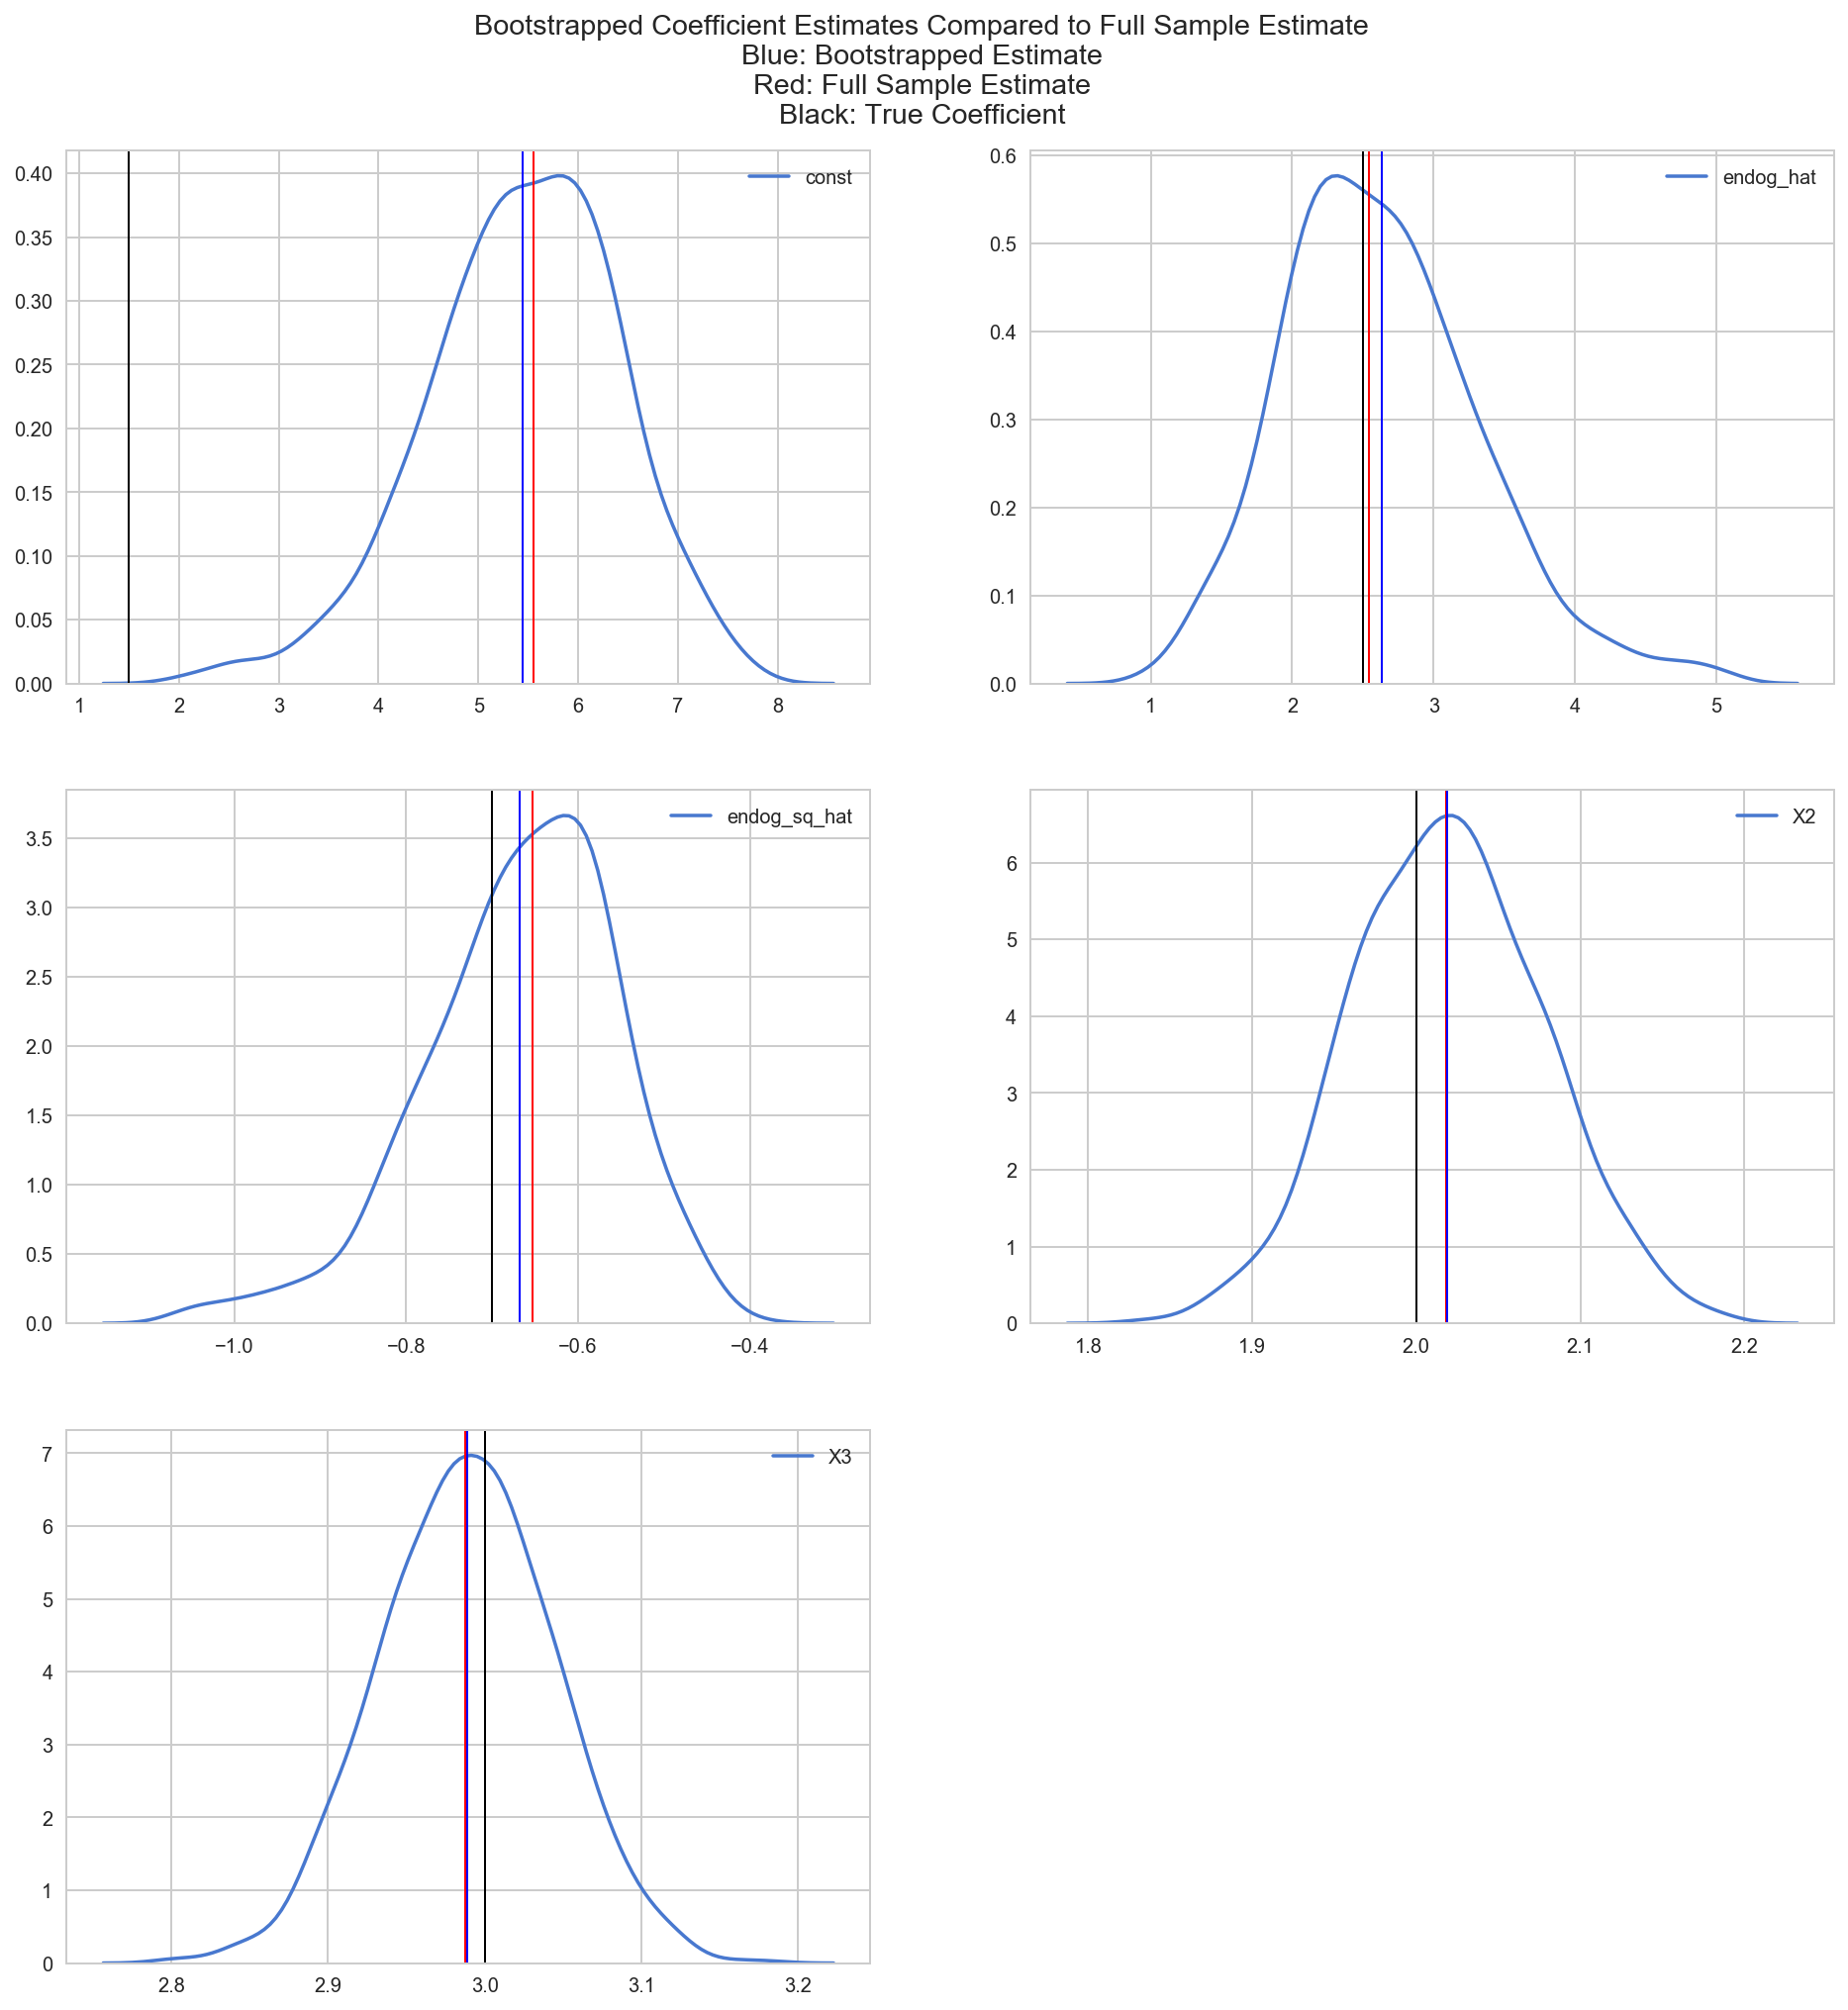

In [18]:
# Creating distribution plots
custom_dist_plots(result1, true_coeffs = [1.5, 2.5, -0.7, 2, 3])

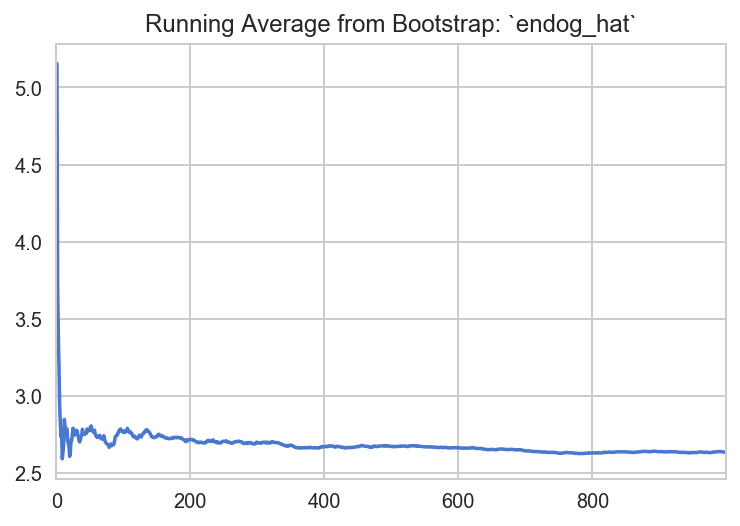

In [19]:
# Coefficient Path
coeff_path_plot(result1, 'endog_hat', n_bootstraps)

# Weak Instruments

In [3]:
np.random.seed(49067)

## Data Generation ##
n = 1500
n_bootstraps = 3000

## DGP ##
# X1 is endogenous because we are going to leave X4 out as an ommitted var and cov(X1, X4) =/= 0
# Z's are the instruments we will use for X1
var_names = ['X1', 'X2', 'X3', 'X4', 'Z1', 'Z2']
means = [3, -1.5, 1.1, 2.3, -1, 3]
cov = [[1, 0, 0, 0.75, 0.25, 0.2],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0.75, 0, 0, 1, 0, 0],
       [0.25, 0, 0, 0, 1, 0],
       [0.2, 0, 0, 0, 0, 1]]

X1, X2, X3, X4, Z1, Z2 = np.random.multivariate_normal(means, cov, n).T

# Normal, mean zero errors
epsilon = np.random.normal(0, 1, n)

# True model:
Y = 1.5 + 2.5*X1 - 0.7*(X1)**2 + 2*X2 + 3*X3 + 2*X4 + epsilon

## Constructing the data sets ##
# Note: we leave out X4 as the omitted variable from which endogeneity is arising
exogenous = pd.DataFrame({'X2' : X2, 'X3' : X3})
exogenous = sm.add_constant(exogenous)
endogenous = pd.DataFrame({'X1' : X1})
instruments = pd.DataFrame({'Z1' : Z1, 'Z2' : Z2})
Y = pd.DataFrame({'Y' : Y})

## Estimating the models ##
model2 = q2sls.Quadratic2SLS(Y, exogenous, endogenous, instruments)
result2 = model2.fit(cov_type='Bootstrap', n_iter = n_bootstraps)

## Results ##
results_df(result2, true_coeffs = [1.5, 2.5, -0.7, 2, 3])

100%|██████████| 3000/3000 [00:30<00:00, 97.20it/s]


,Bootstrapped,Full_Sample,True_Coeffs
const,10.365047,13.073439,1.5
endog_hat,-1.165948,-3.144631,2.5
endog_sq_hat,-0.028475,0.292639,-0.7
X2,1.928408,1.921527,2.0
X3,2.973806,2.977758,3.0


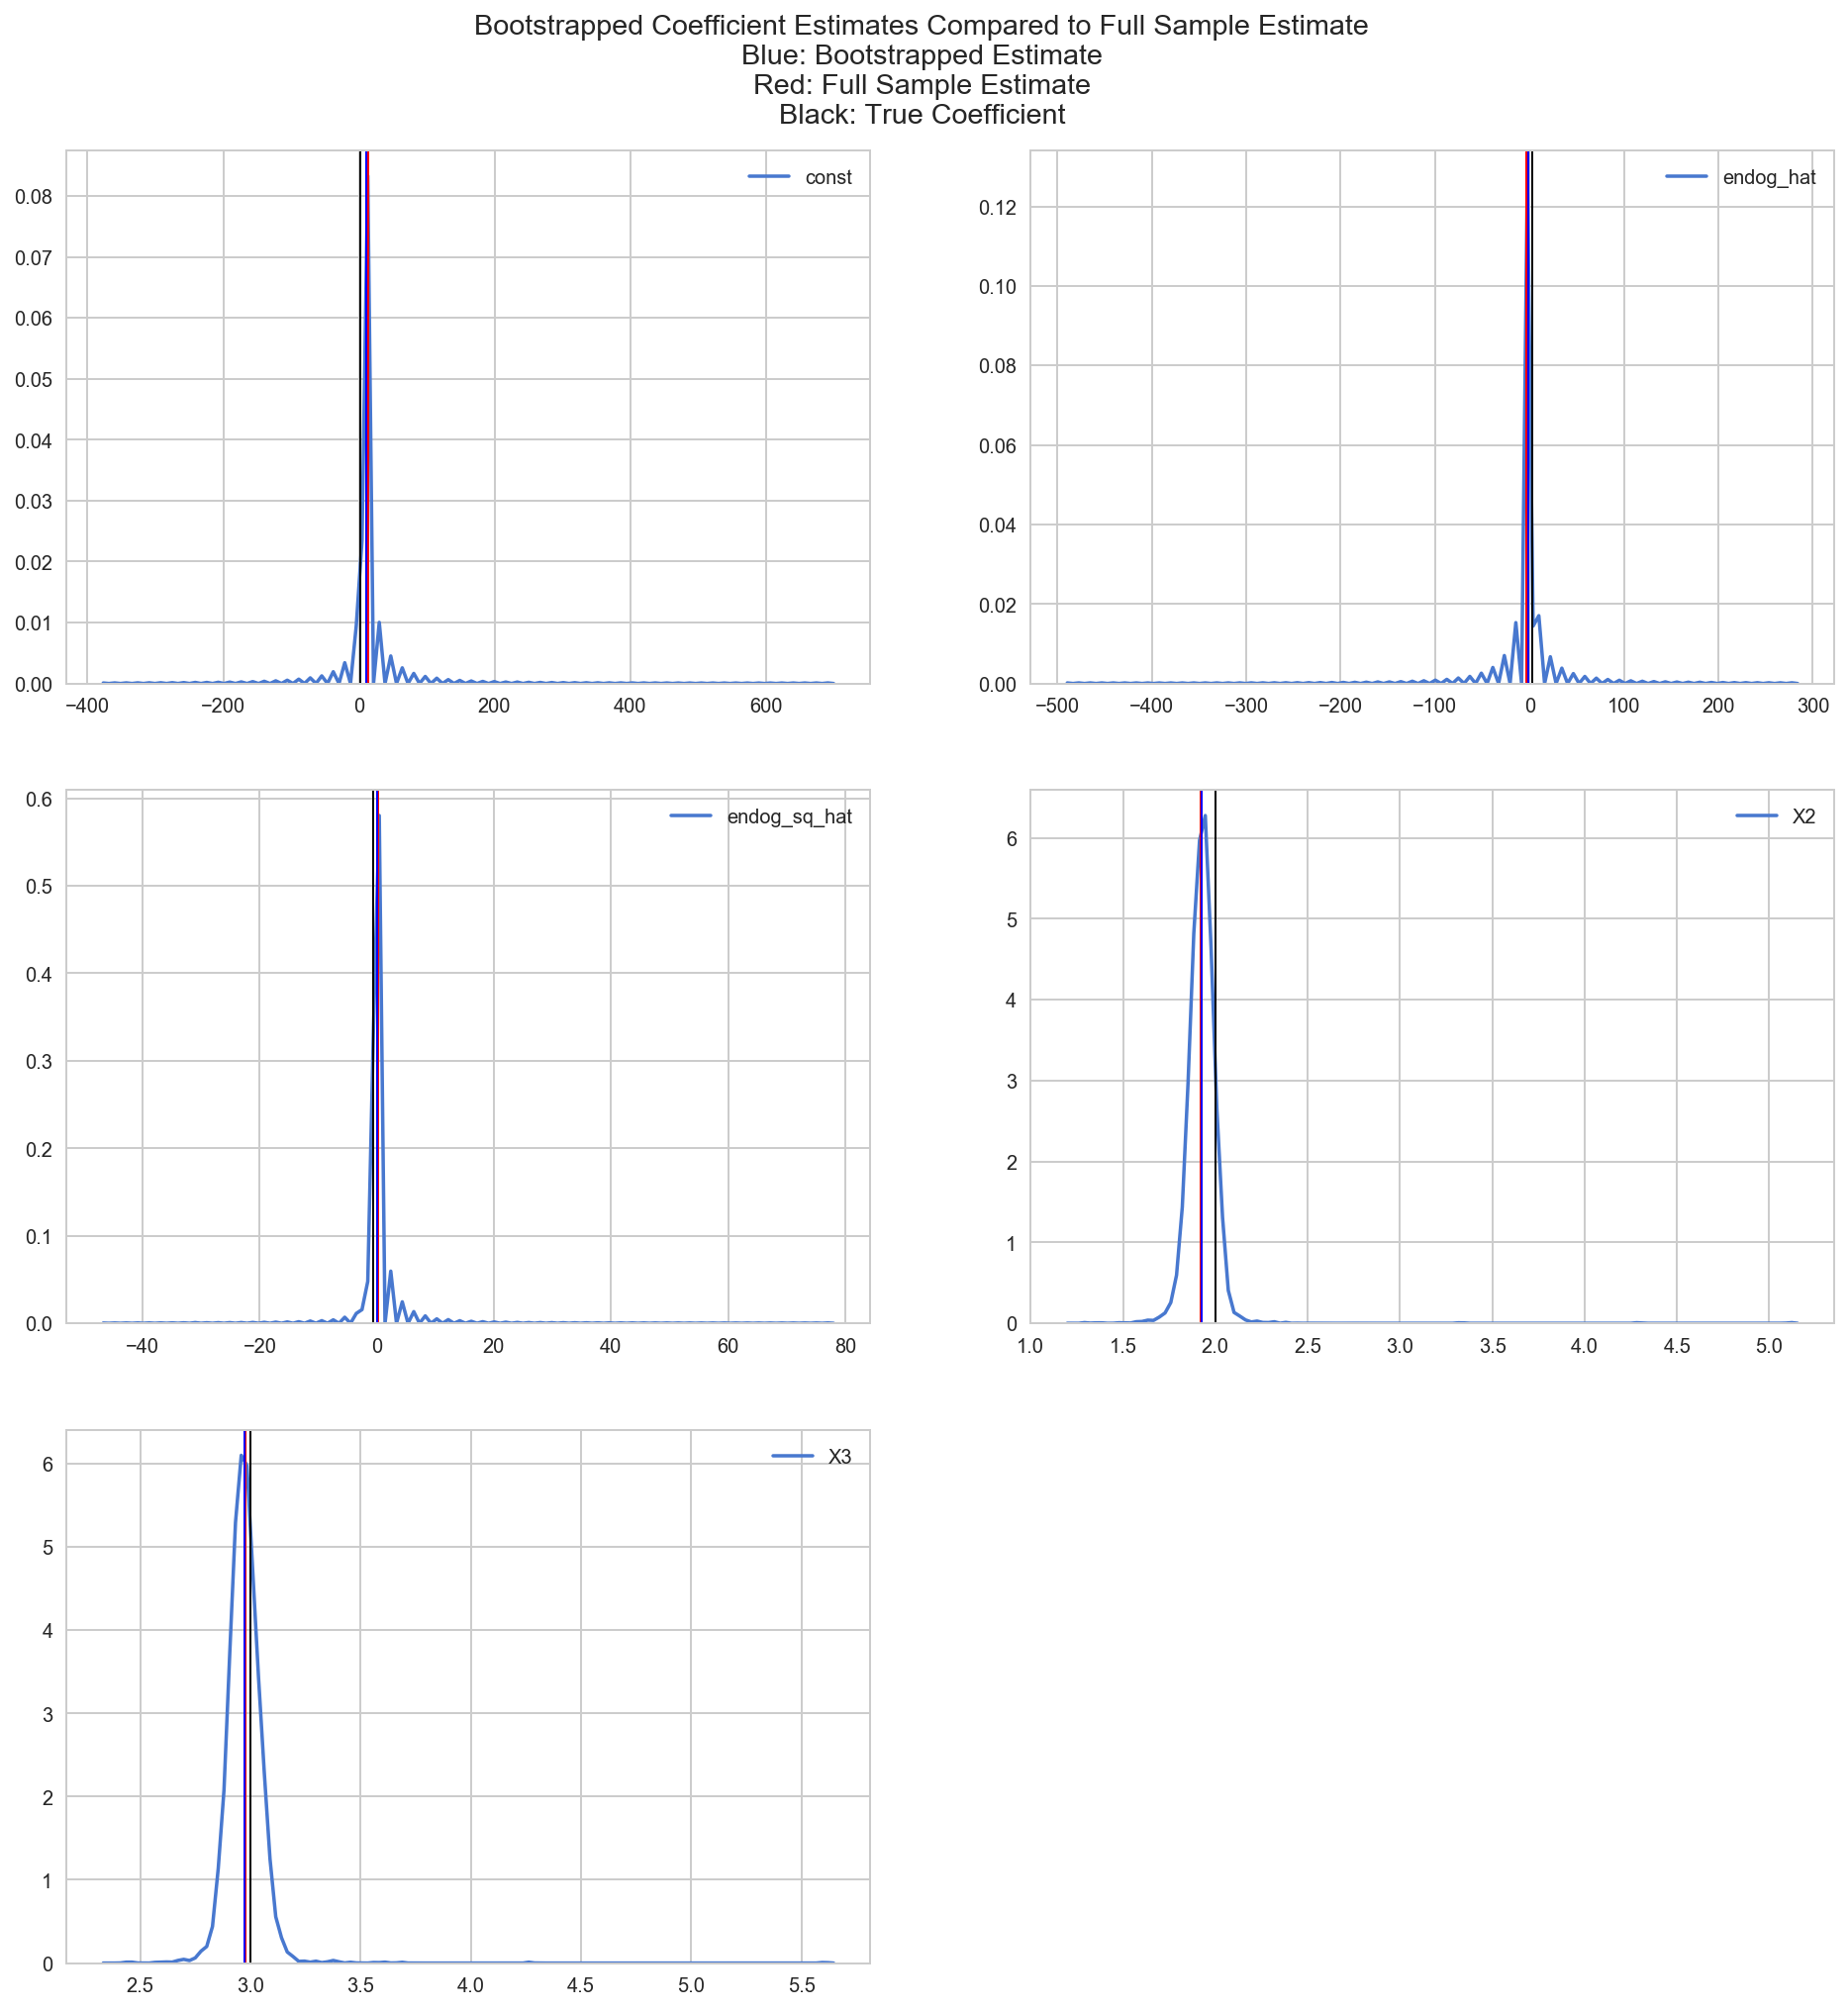

In [4]:
# Creating distribution plots
custom_dist_plots(result2, true_coeffs = [1.5, 2.5, -0.7, 2, 3])

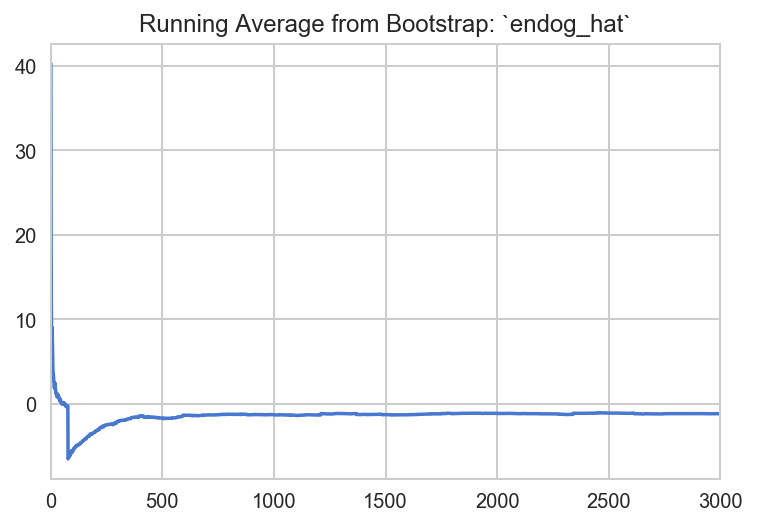

In [5]:
# Coefficient Path
coeff_path_plot(result2, 'endog_hat', n_bootstraps)

# Old Model
This DGP is a bit funky

In [3]:
np.random.seed(42656)

n = 1500
n_bootstraps = 3000

X2 = np.random.binomial(1, 0.7, n)
X3 = np.random.normal(2, 1, n)
X5 = np.random.normal(1, 0.5, n)
X4 = np.random.normal(1.5, 2, n)
Z1 = np.random.normal(2, 1, n)
Z2 = np.random.binomial(1, 0.4, n)
Z3 = np.random.normal(1, 0.75, n)
Z4 = np.random.binomial(1, 0.6, n)
epsilon = np.random.normal(0, 1, n)
eta = np.random.normal(0, 1, n)

# Model 1:
X1 = 1 + 2*X3 - 3*X4 + 2*Z1 + 2*Z2 - Z3 + 3*Z4 + eta
Y = 0.7 + 1.2*X1 - 0.1*(X1)**2 + 0.3*X2 + 0.2*X3 + 0.4*X4 + 0.3*X5 + epsilon

# Constructing the data sets
exogenous = pd.DataFrame({'X2' : X2, 'X3' : X3, 'X5' : X5})
exogenous = sm.add_constant(exogenous)
endog1 = pd.DataFrame({'X1' : X1})
instruments3 = pd.DataFrame({'Z1' : Z1, 'Z2' : Z2, 'Z3' : Z3, 'Z4' : Z4})
Y = pd.DataFrame({'Y' : Y})

## Estimating the models
model3 = q2sls.Quadratic2SLS(Y, exogenous, endog1, instruments3)
result3 = model3.fit(cov_type='Bootstrap', n_iter = n_bootstraps)

## Results
results_df(result3, true_coeffs = [0.7, 1.2, -0.1, 0.3, 0.2, 0.3])

100%|██████████| 3000/3000 [00:47<00:00, 63.64it/s]


,Bootstrapped,Full_Sample,True_Coeffs
const,1.457337,1.433421,0.7
endog_hat,1.207528,1.209800,1.2
endog_sq_hat,-0.102851,-0.102651,-0.1
X2,0.352271,0.350880,0.3
X3,0.237863,0.234558,0.2
X5,0.209611,0.210265,0.3


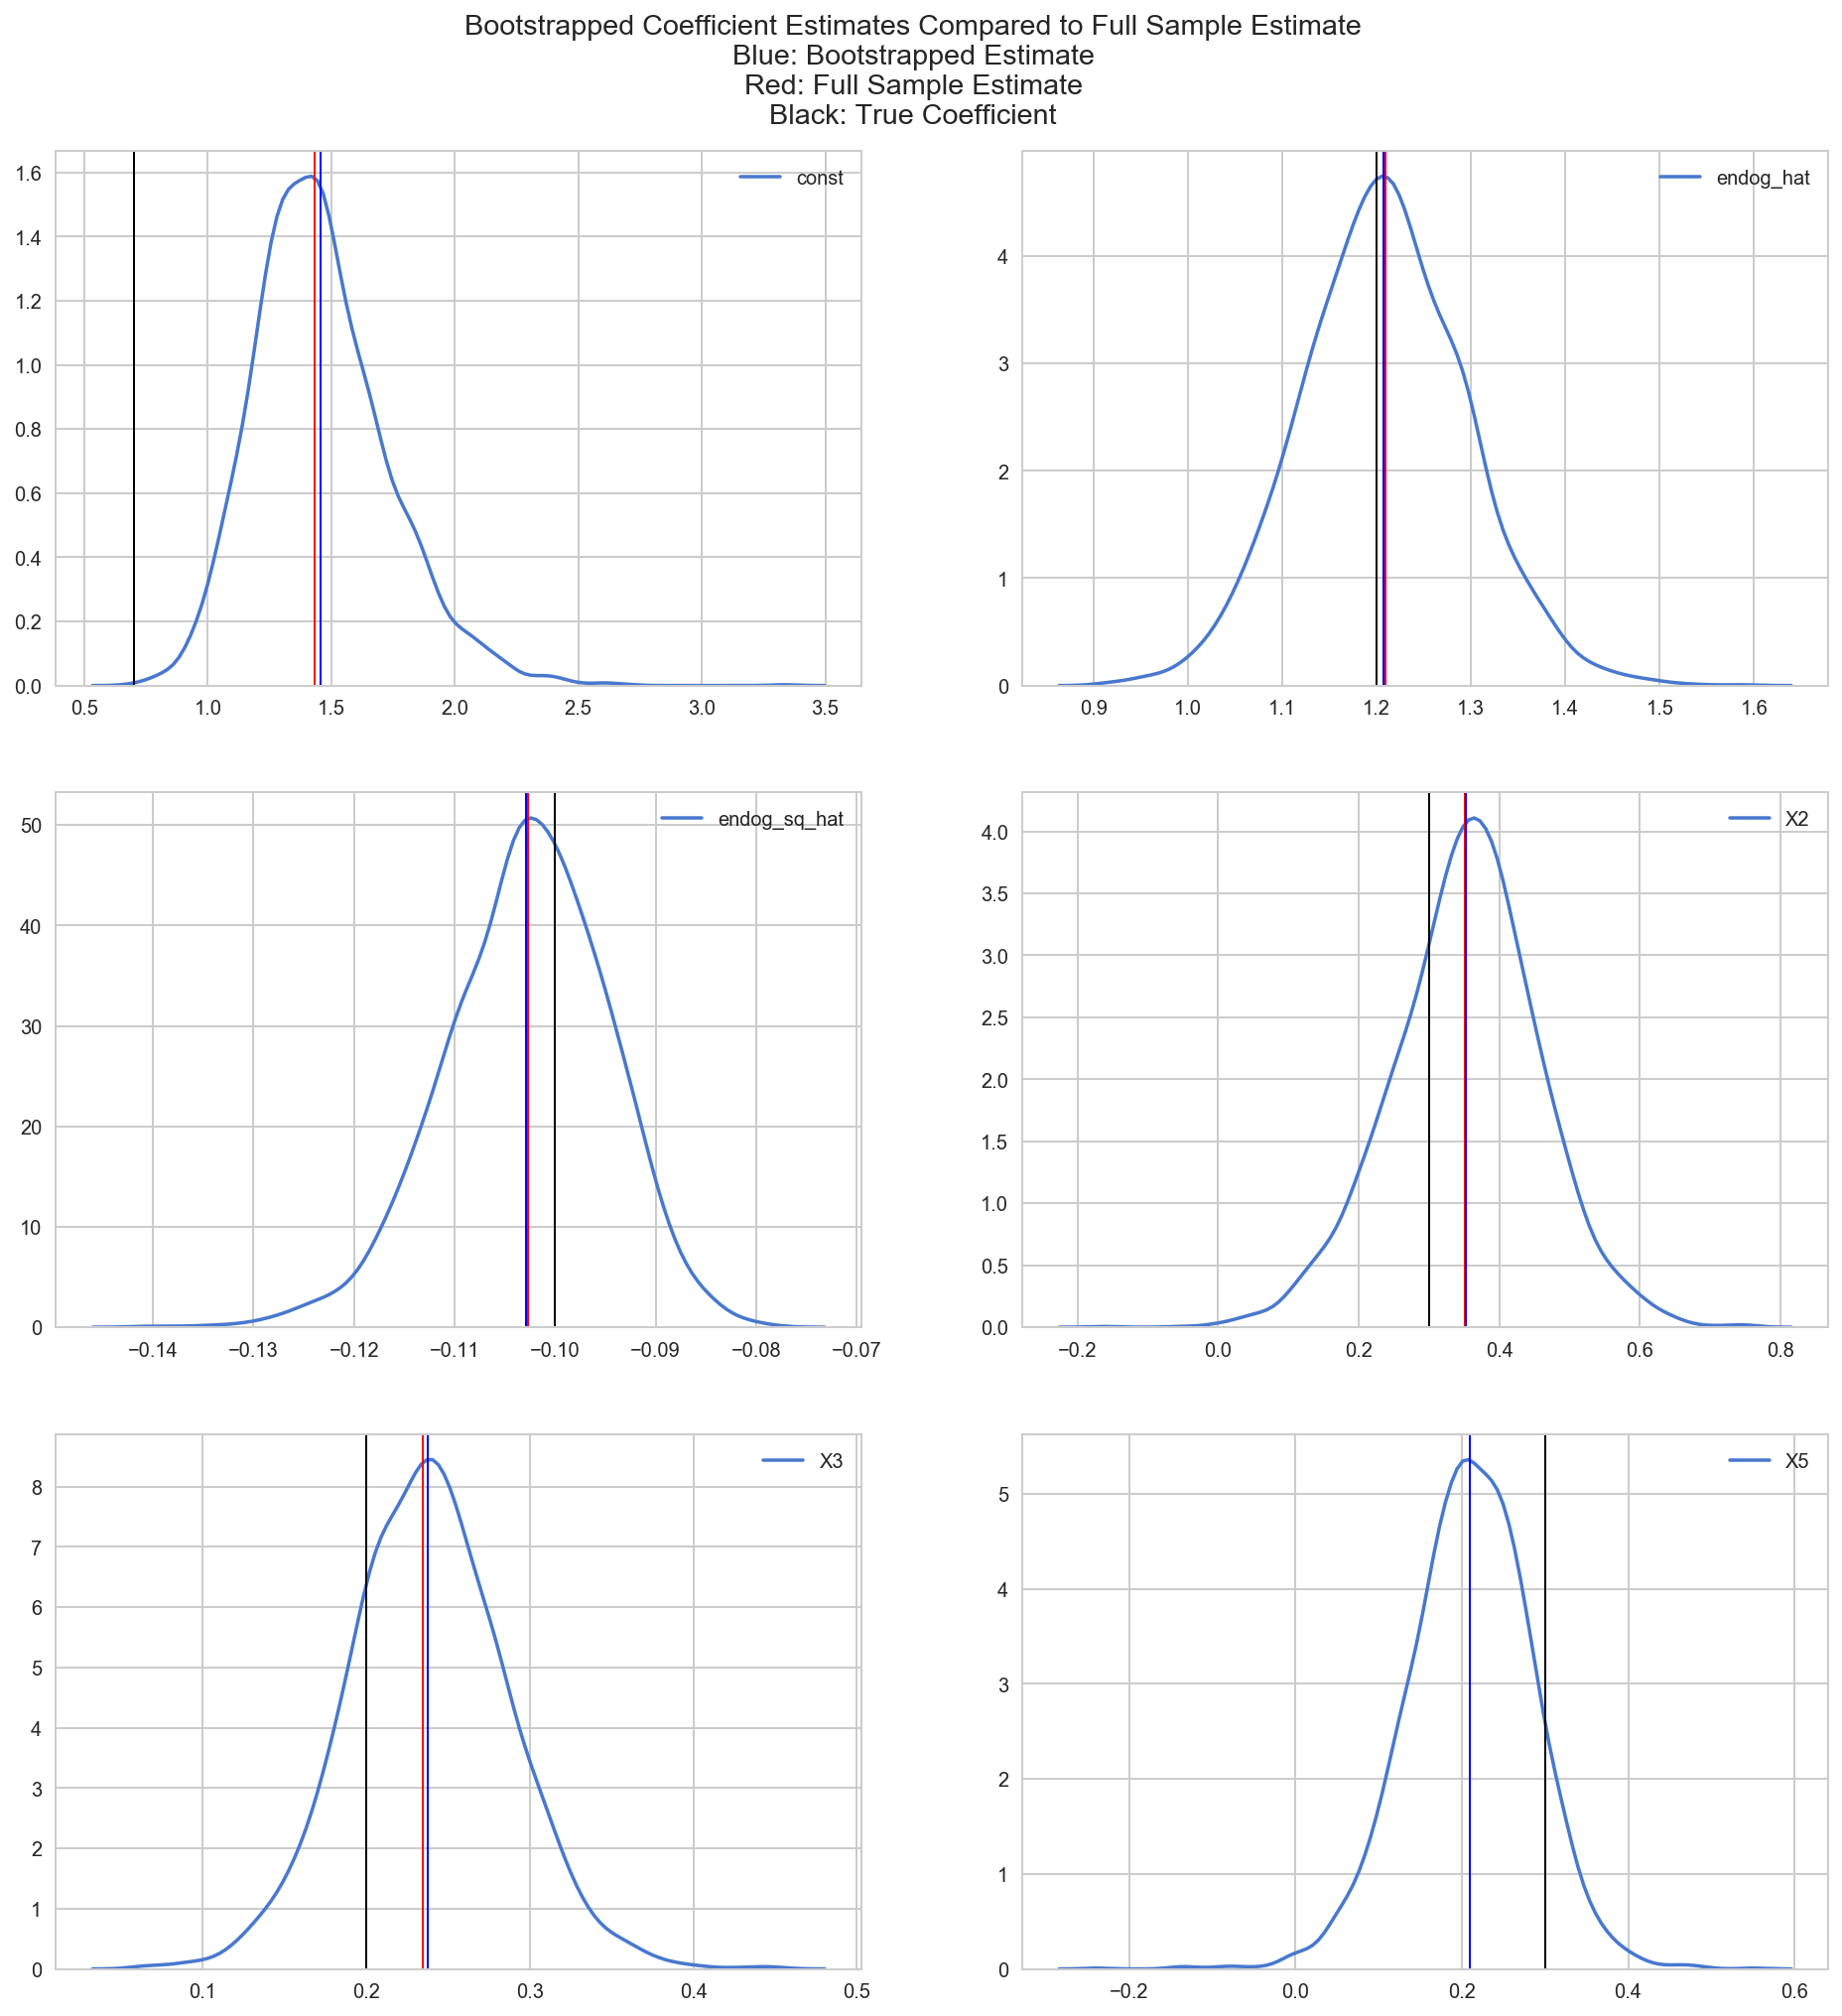

In [12]:
# Creating distribution plots
custom_dist_plots(result3, true_coeffs = [0.7, 1.2, -0.1, 0.3, 0.2, 0.3])

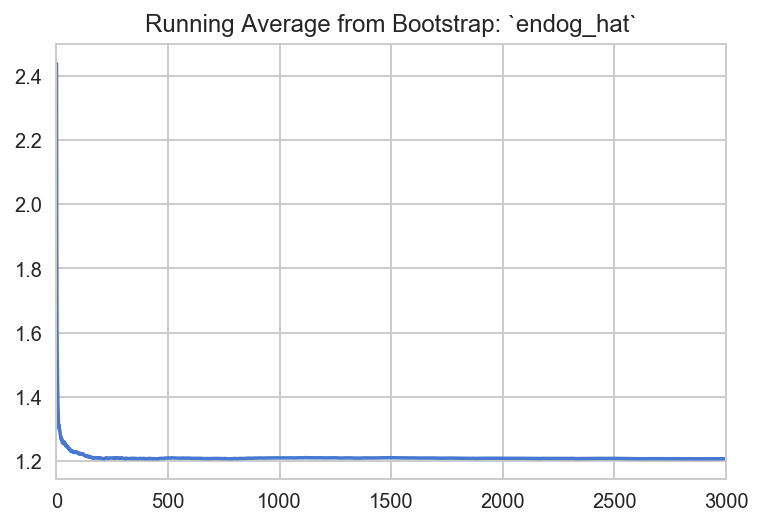

In [7]:
# Coefficient Path
coeff_path_plot(result3, 'endog_hat', n_bootstraps)

In [20]:
np.random.seed(42656)

n = 1500
n_bootstraps = 3000

X2 = np.random.binomial(1, 0.7, n)
X3 = np.random.normal(2, 1, n)
X5 = np.random.normal(1, 0.5, n)
X4 = np.random.normal(1.5, 2, n)
Z1 = np.random.normal(2, 1, n)
Z2 = np.random.binomial(1, 0.4, n)
Z3 = np.random.normal(1, 0.75, n)
Z4 = np.random.binomial(1, 0.6, n)
epsilon = np.random.normal(0, 1, n)
### NOW `eta` HAS A LARGER VARIANCE, SO X1 HAS MORE NOISE
eta = np.random.normal(0, 4, n)

# Model 1:
X1 = 1 + 2*X3 - 3*X4 + 2*Z1 + 2*Z2 - Z3 + 3*Z4 + eta
Y = 0.7 + 1.2*X1 - 0.1*(X1)**2 + 0.3*X2 + 0.2*X3 + 0.4*X4 + 0.3*X5 + epsilon

# Constructing the data sets
exogenous = pd.DataFrame({'X2' : X2, 'X3' : X3, 'X5' : X5})
exogenous = sm.add_constant(exogenous)
endog1 = pd.DataFrame({'X1' : X1})
instruments3 = pd.DataFrame({'Z1' : Z1, 'Z2' : Z2, 'Z3' : Z3, 'Z4' : Z4})
Y = pd.DataFrame({'Y' : Y})

## Estimating the models
model4 = q2sls.Quadratic2SLS(Y, exogenous, endog1, instruments3)
result4 = model4.fit(cov_type='Bootstrap', n_iter = n_bootstraps)

## Results
results_df(result4, true_coeffs = [0.7, 1.2, -0.1, 0.3, 0.2, 0.3])

100%|██████████| 3000/3000 [00:44<00:00, 66.86it/s]


,Bootstrapped,Full_Sample,True_Coeffs
const,1.601184,1.560019,0.7
endog_hat,1.230383,1.232237,1.2
endog_sq_hat,-0.105050,-0.104673,-0.1
X2,0.338821,0.340193,0.3
X3,0.231821,0.227405,0.2
X5,0.213594,0.214042,0.3


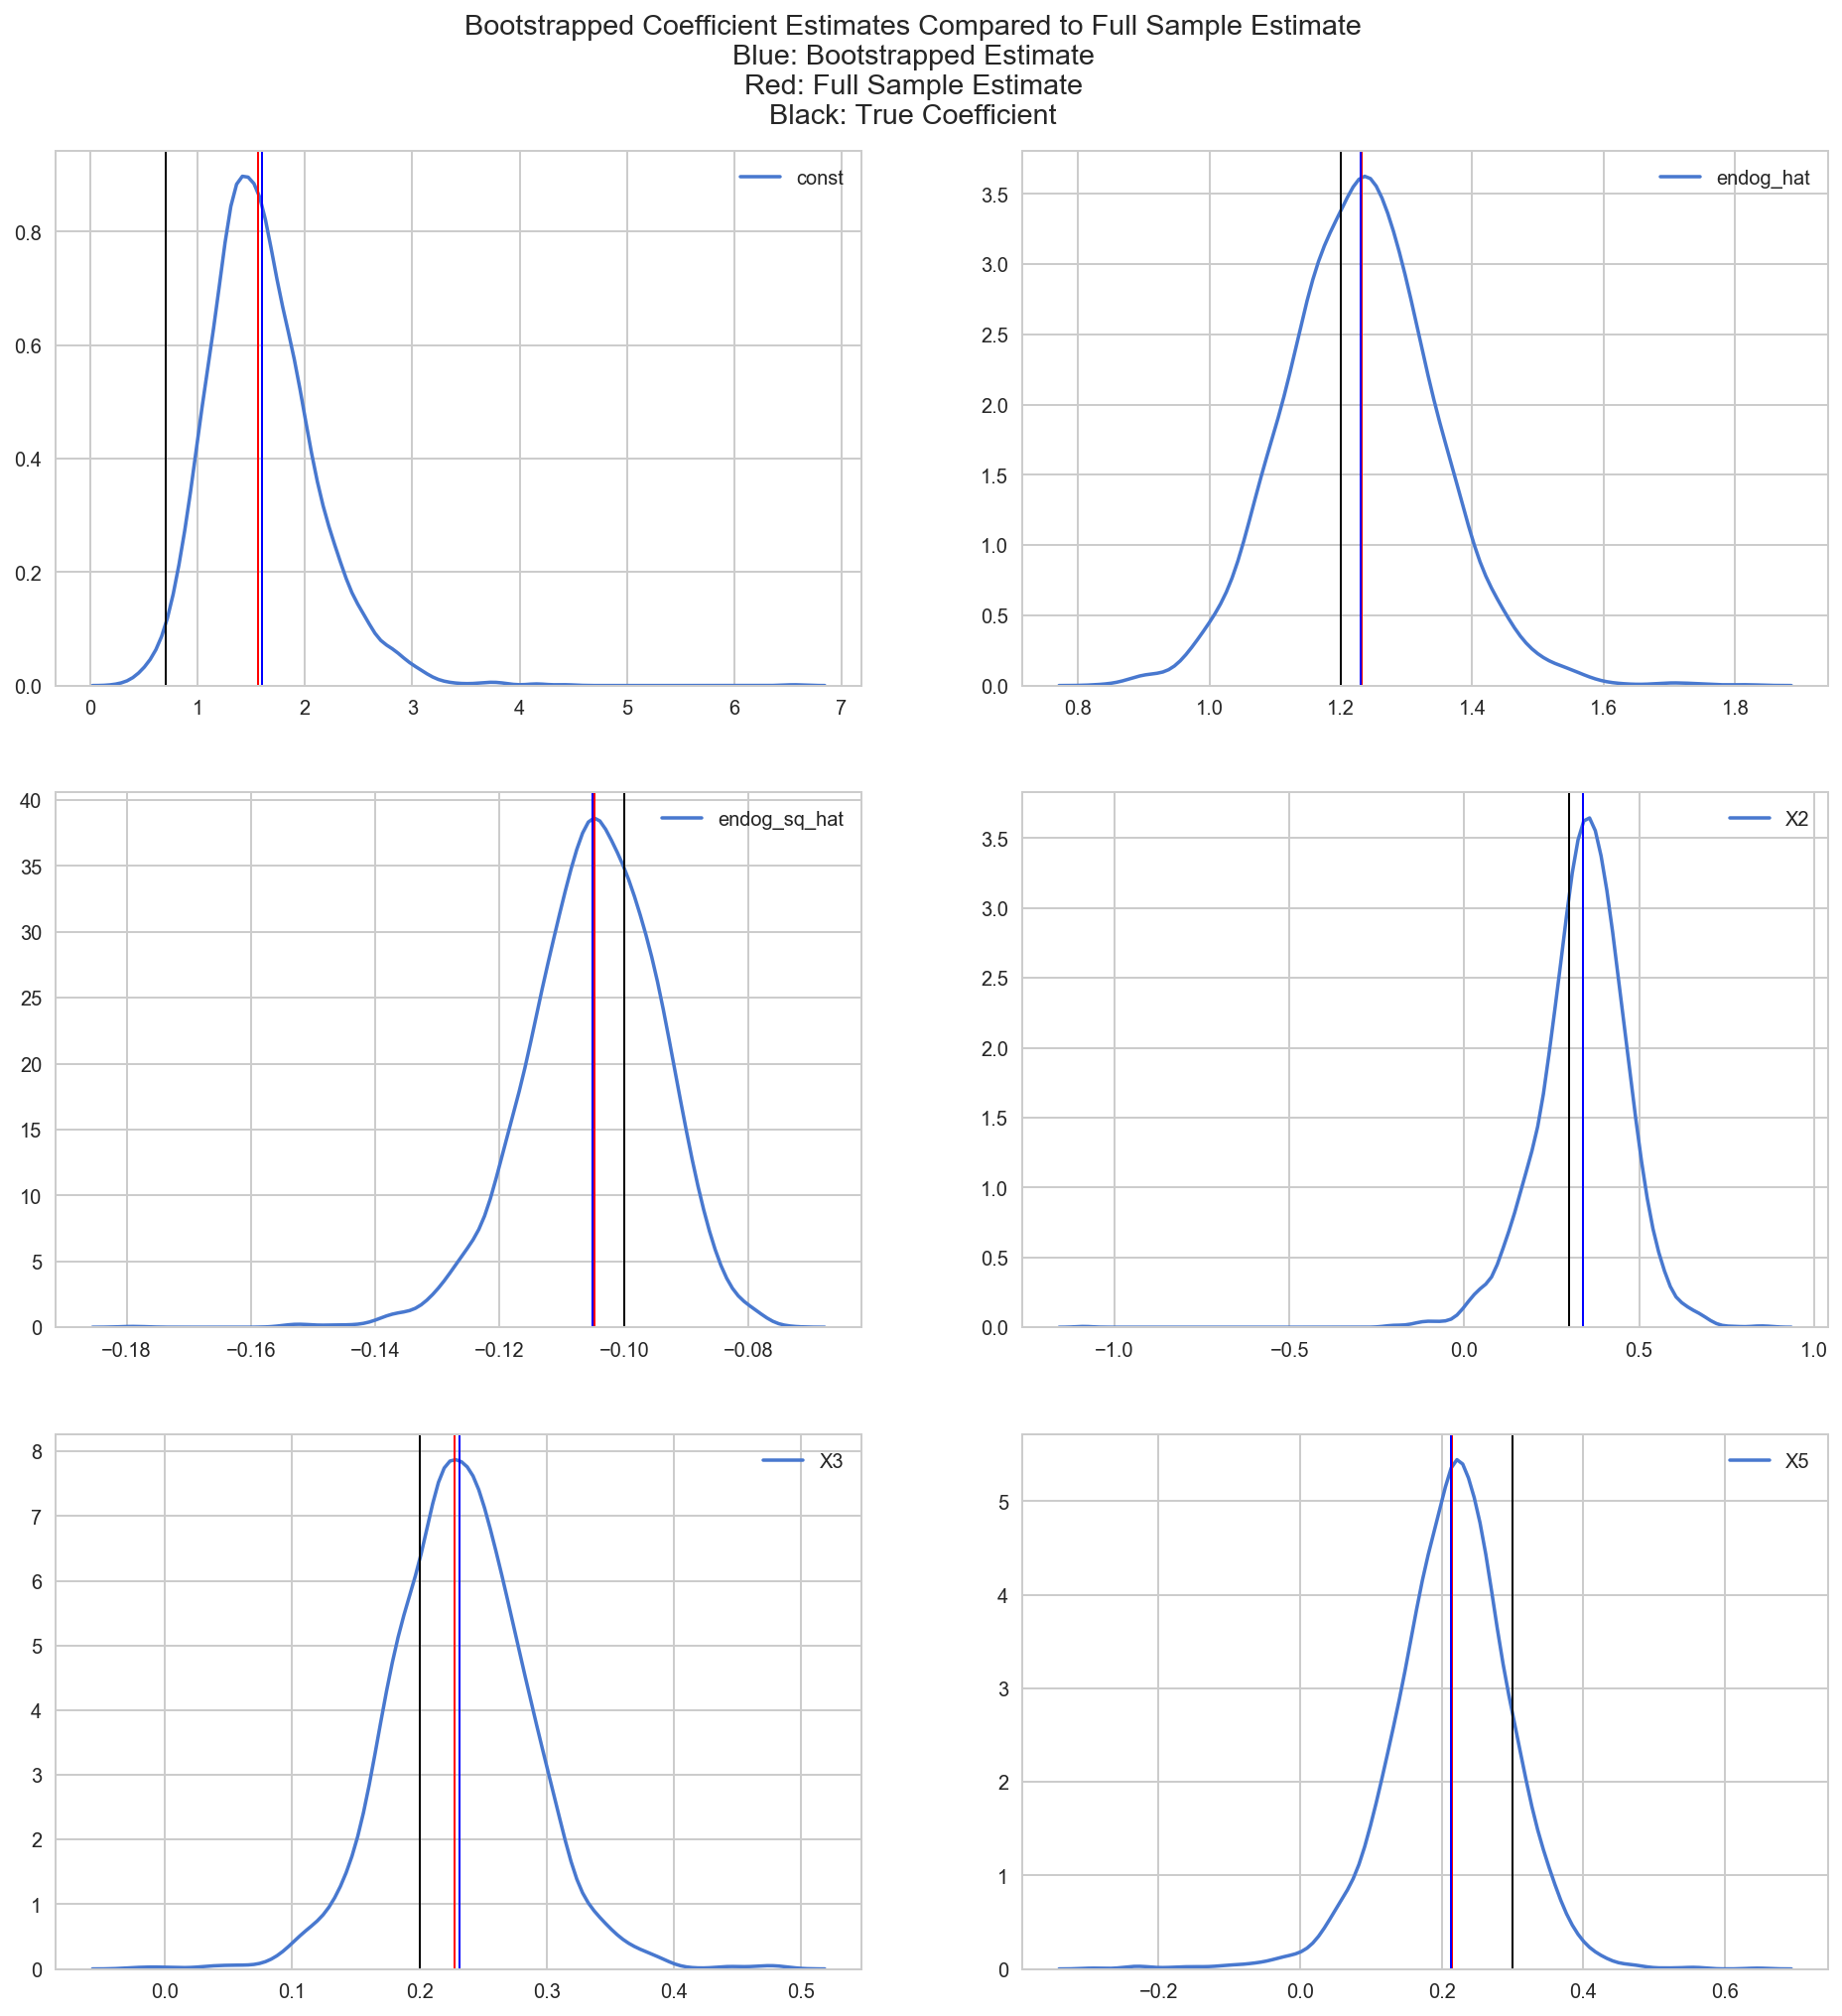

In [21]:
# Creating distribution plots
custom_dist_plots(result4, true_coeffs = [0.7, 1.2, -0.1, 0.3, 0.2, 0.3])

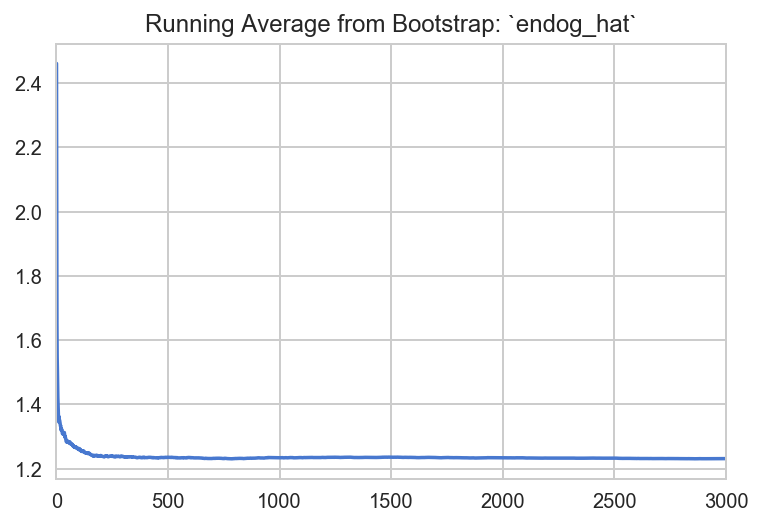

In [22]:
# Coefficient Path
coeff_path_plot(result4, 'endog_hat', n_bootstraps)